# Demo the Arbitrageur Agent Logic

This notebook:

1. Fetches the latest crvusd contract data into Python objects using `crvusdsim`.
2. Fetches prices and `ExternalMarket`s from the `baseline` scenario.
3. Instantiates an Arbitrageur agent.
4. Checks if there are profitable arbitrages and performs them.

In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from crvusdsim.pool import get
from src.agents.arbitrageur import Arbitrageur
from src.sim.scenario import Scenario
from src.utils.poolgraph import PoolGraph


%load_ext autoreload
%autoreload 2

In [2]:
arbitrageur = Arbitrageur()

ETH_POOL = "weth"
sim_market = get(ETH_POOL, bands_data="controller")

pool = sim_market.pool
stableswap_pools = sim_market.stableswap_pools

In [3]:
# Verify snapshot context works on StableSwap pools from crvusdsim
i, j = 1, 0

stableswap_pool = stableswap_pools[2]
high = stableswap_pool.get_max_trade_size(i, j)
prev_bals = stableswap_pool.balances.copy()

print("Pre Trade")
print("Balances", prev_bals)
print("High", high)
print("Allowance", stableswap_pool.coins[0].balanceOf[stableswap_pool.address])
print()

with stableswap_pool.use_snapshot_context():
    amt_out = stableswap_pool.trade(i, j, high)
    swap_bals = stableswap_pool.balances.copy()
    print("Post Trade")
    print("Amount out", amt_out)
    print("Balances", swap_bals)
    print("Allowance", stableswap_pool.coins[0].balanceOf[stableswap_pool.address])
    print()

new_bals = stableswap_pool.balances.copy()
print("After reversing snapshot context")
print("Balances", new_bals)
print("Allowance", stableswap_pool.coins[0].balanceOf[stableswap_pool.address])

assert prev_bals == new_bals, (prev_bals, new_bals)
assert swap_bals != new_bals

Pre Trade
Balances [10008658850325, 25873939907962300163632541]
High 12842547157360454826337406
Allowance 10008658850325

Post Trade
Amount out 9907581404595
Balances [100582017117, 38716487065322754989969947]
Allowance 101077445730

After reversing snapshot context
Balances [10008658850325, 25873939907962300163632541]
Allowance 10008658850325


In [4]:
# Verify snapshot context works on LLAMMA pools
i, j = 0, 1
high = pool.get_max_trade_size(i, j)

prev_bals = (sum(pool.bands_x.values()), sum(pool.bands_y.values()))

print("Pre Trade")
print("Balances", prev_bals)
print("High", high)
print("Stablecoin", pool.BORROWED_TOKEN.balanceOf[pool.address])
print("Collateral", pool.COLLATERAL_TOKEN.balanceOf[pool.address])
print()

with pool.use_snapshot_context():
    amt_in, amt_out, _ = pool.trade(i, j, high)
    swap_bals = (sum(pool.bands_x.values()), sum(pool.bands_y.values()))
    print("Amount in", high)
    print("Amount out", amt_out)
    print()
    print("Post Trade")
    print("Balances", swap_bals)
    print("Stablecoin", pool.BORROWED_TOKEN.balanceOf[pool.address])
    print("Collateral", pool.COLLATERAL_TOKEN.balanceOf[pool.address])
    print()

new_bals = (sum(pool.bands_x.values()), sum(pool.bands_y.values()))
print("After reversing snapshot context")
print("Balances", new_bals)
print("Stablecoin", pool.BORROWED_TOKEN.balanceOf[pool.address])
print("Collateral", pool.COLLATERAL_TOKEN.balanceOf[pool.address])

assert prev_bals == new_bals, (prev_bals, new_bals)
assert swap_bals != new_bals

Pre Trade
Balances (0, 15971445880068407183360)
High 40112480040711511589864028
Stablecoin 0
Collateral 15971445880068407183360

Amount in 40112480040711511589864028
Amount out 12702926360139514396671

Post Trade
Balances (40112480040711511589623376, 3268519519928892786689)
Stablecoin 40112480040711511589864028
Collateral 3268519519928892786689

After reversing snapshot context
Balances (0, 15971445880068407183360)
Stablecoin 0
Collateral 15971445880068407183360


In [5]:
# Generate markets and prices
config = "../src/configs/scenarios/baseline.json"
scenario = Scenario(config)
markets = scenario.generate_markets()
prices = scenario.generate_pricepaths("../" + scenario.price_config)
scenario.update_market_prices(prices[-1])

[INFO][03:38:54][root]-556007: Reading price config from ../src/configs/scenarios/baseline.json.
[INFO][03:38:54][root]-556007: Fetching 1inch quotes.


[INFO][03:39:01][root]-556007: We have 443520 quotes.
[INFO][03:39:01][root]-556007: Fitting external markets against 1inch quotes.
[INFO][03:39:01][root]-556007: Reading price config from ../src/configs/prices/1h_1696108632_1701289032.json.


In [6]:
# Create a list of all stableswap pools, LLAMMAs, and External Markets.
markets_lst = list(markets.values())
pools = stableswap_pools + [pool] + markets_lst
print(
    f"There are {len(pools)} total pools:\nStableSwap: {len(stableswap_pools)}\nLLAMMA: 1\nExternal Markets: {len(markets_lst)}"
)

There are 20 total pools:
StableSwap: 4
LLAMMA: 1
External Markets: 15


In [7]:
n = 3
graph = PoolGraph(pools)
cycles = graph.find_cycles(n=n)
cycles

[INFO][03:39:01][root]-556007: Found 20 valid cycles of length 3.


[Cycle(Trades: [Swap(pool=<SimCurveStableSwapPool address=0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0 chain=mainnet>, i=0, j=1, amt=None), Swap(pool=<SimCurveStableSwapPool address=0xca978a0528116dda3cba9acd3e68bc6191ca53d0 chain=mainnet>, i=1, j=0, amt=None), Swap(pool=External Market (TUSD, USDP), i=1, j=0, amt=None)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=<SimCurveStableSwapPool address=0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0 chain=mainnet>, i=0, j=1, amt=None), Swap(pool=<SimCurveStableSwapPool address=0x4dece678ceceb27446b35c672dc7d61f30bad69e chain=mainnet>, i=1, j=0, amt=None), Swap(pool=External Market (TUSD, USDC), i=1, j=0, amt=None)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=<SimCurveStableSwapPool address=0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0 chain=mainnet>, i=0, j=1, amt=None), Swap(pool=<SimCurveStableSwapPool address=0x390f3595bca2df7d23783dfd126427cceb997bf4 chain=mainnet>, i=1, j=0, amt=None), Swap(pool=External Market (TUSD, USDT), i=1, j=0

In [8]:
df = pd.DataFrame(
    columns=["amt_optimize", "amt_linspace", "profit_optimize", "profit_linspace"]
)

for i, cycle in enumerate(cycles):
    try:
        # This is orders of magnitude slower than `optimize`
        trade = cycle.trades[0]
        high = trade.pool.get_max_trade_size(trade.i, trade.j)
        amts = np.linspace(0, high, 1000)
        amts = [int(amt) for amt in amts]
        profits = [cycle.populate(amt) for amt in amts]

        best_amt_linspace = int(amts[np.argmax(profits)])
        best_profit_linspace = int(max(profits))

        cycle.optimize()

        df.loc[i] = [
            cycle.trades[0].amt,
            best_amt_linspace,
            cycle.expected_profit,
            best_profit_linspace,
        ]

    except Exception as e:
        logging.error(f"Cycle {i} failed to optimize: {e}")

df["profit_linspace"] = df["profit_linspace"].astype(float)
df["profit_optimize"] = df["profit_optimize"].astype(float)
df = df.round(3)
df

,amt_optimize,amt_linspace,profit_optimize,profit_linspace
0,98012208259843286368256,70710048681480090025984,36.902,39.0
1,218850735460574539284480,41902251070506718461952,-72.324,1.0
2,830051623128941180485632,0,-1765.670,0.0
3,879261247348679741800448,1063269620914107969437696,26677.883,27640.0
4,1761.0,0.0,-0.000,0.0
5,349102849261943.0,0.0,-0.000,0.0
6,510276868268790.0,0.0,-0.000,0.0
7,742260321156379453685760,830440290077976347803648,21296.374,21472.0
8,522871770980.0,0.0,-1013.197,0.0
9,136658284642.0,53619777399.0,24.078,20.0


[WARNING][03:39:35][root]-556007: LLAMMA amt_in 1 != in_amount_done 0.


Best amount linspace: 1063269620914107969437696
Best profit linspace: 27640.158456553425
Best amount optimize: 879261247348679741800448
Best profit optimize: 26677.882585783012


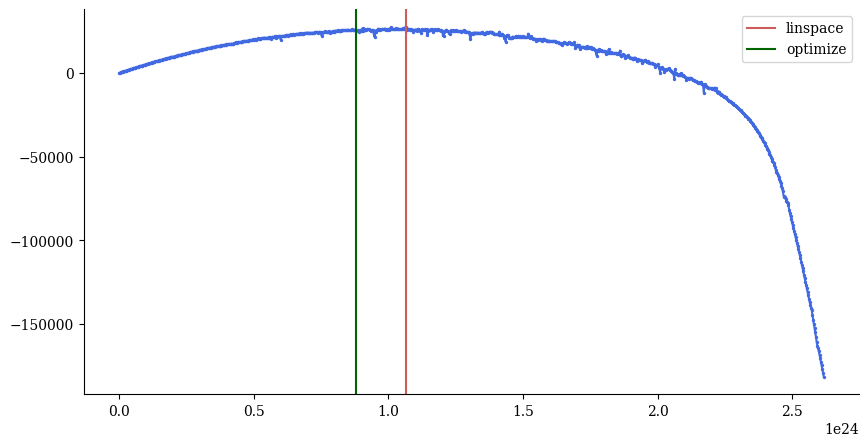

In [10]:
# TODO this curve is probably not smooth because:
# 1. The decimals are not being treated correctly between trades
# 2. The state of each pool is not being snapshot correctly (i.e. it's changing)

i = 3
cycle = cycles[i]

trade = cycle.trades[0]
high = trade.pool.get_max_trade_size(trade.i, trade.j)
amts = np.linspace(1, high, 1000)
amts = [int(amt) for amt in amts]
profits = [cycle.populate(amt) for amt in amts]

best_amt_linspace = amts[np.argmax(profits)]
best_profit_linspace = max(profits)

# compare
cycle.optimize()
best_amt_optimize = cycle.trades[0].amt
best_profit_optimize = cycle.expected_profit

f, ax = plt.subplots(figsize=(10, 5))
ax.scatter(amts, profits, color="royalblue", s=2)
ax.plot(amts, profits, color="royalblue")
ax.axvline(best_amt_linspace, color="indianred", label="linspace")
ax.axvline(best_amt_optimize, color="darkgreen", label="optimize")

ax.legend()

print(f"Best amount linspace: {best_amt_linspace}")
print(f"Best profit linspace: {best_profit_linspace}")
print(f"Best amount optimize: {best_amt_optimize}")
print(f"Best profit optimize: {best_profit_optimize}")